## Imports

In [1]:
from data_loader import prepare_data_loaders, get_data_statistics
from config import Config
from model import initialize_model
from train import training_loop
from evaluate import evaluate_model, visualize_predictions, plot_training_history

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

## Initialize data loaders and obtain dataset statistics

In [2]:
batch_size = 64
validation_split = 0.2

train_loader, val_loader, test_loader = prepare_data_loaders(batch_size=batch_size, validation_split=validation_split)

train_statistics = get_data_statistics(train_loader)
val_statistics = get_data_statistics(val_loader)
test_statistics = get_data_statistics(test_loader)

stats = {
    "train": train_statistics,
    "val": val_statistics,
    "test": test_statistics
}

for type in stats.keys():
    print(f"{type} set statistics:\nMean: {stats[type]["mean"]}\nStandard deviation: {stats[type]["std"]}\n")

train set statistics:
Mean: tensor([-0.7386])
Standard deviation: tensor([0.6164])

val set statistics:
Mean: tensor([-0.7392])
Standard deviation: tensor([0.6155])

test set statistics:
Mean: tensor([-0.7352])
Standard deviation: tensor([0.6207])



## Display certain samples
Partially referenced from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [3]:
def show_image(img: torch.Tensor):
    """
    Helper function to display an image.

    args:
    - img (torch.Tensor): an image as a PyTorch tensor
    """
    img = img / 2 + 0.5         # reverts normalization, changes [-1.0, 1.0] back to [0.0, 1.0]
    img_np = img.numpy()

    plt.imshow(np.transpose(img_np, (1,2,0)))   # C,H,W to H,W,C

    plt.show()

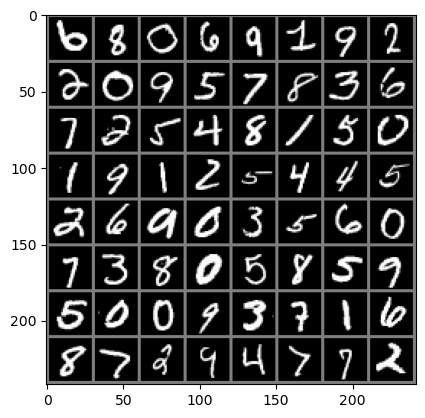

Labels: 
6 8 0 6 9 1 9 2 
2 0 9 5 7 8 3 6 
7 2 5 4 8 1 5 0 
1 9 1 2 5 4 4 5 
2 6 9 0 3 5 6 0 
7 3 8 0 5 8 5 9 
5 0 0 9 3 7 1 6 
8 7 2 9 4 7 7 2 


In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_image(torchvision.utils.make_grid(images))                         # displays images
print("Labels: ")                                                       # prints out labels
for i in range(batch_size):
    print(f"{labels[i]}", end=" ")
    if i % 8 == 7:
        print()

## Hyperparameters

In [5]:
num_classes = 10
input_size = (1, 28, 28)

learning_rate = 1e-3
epochs = 8
momentum = 0.9

optimizer = "Adam"
scheduler = "StepLR"

model_path = "./saved_models/"
log_dir = "./logs/"

params = Config(
    batch_size=batch_size,
    val_split=validation_split,
    num_classes=num_classes,
    input_size=input_size,
    learning_rate=learning_rate,
    epochs=epochs,
    momentum=momentum,
    optimizer=optimizer,
    scheduler=scheduler,
    model_path=model_path,
    log_dir=log_dir
)

## Model Setup and Training

In [6]:
model = initialize_model(device=params.device)

In [7]:
criterion = torch.nn.CrossEntropyLoss()


optimizers = {
    "Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad
}

optimizer_args = {
    "params": model.parameters(),
    "lr": params.learning_rate
}

optimizer = optimizers[params.optimizer](**optimizer_args)


schedulers = {
    "StepLR": torch.optim.lr_scheduler.StepLR,
    "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR, 
    "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR, 
    "ReduceLRonPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau
}

scheduler_args = {
    "StepLR": {"step_size": 30, "gamma": 0.1},
    "MultiStepLR": {"milestones": [30, 80], "gamma": 0.1},
    "ExponentialLR": {"gamma": 0.9},
    "ReduceLROnPlateau": {"mode": "min", "factor": 0.1, "patience": 10}
}

scheduler = schedulers[params.scheduler](optimizer, **scheduler_args[params.scheduler])

In [8]:
training_hist = training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=params.epochs,
    device=params.device,
    save_path="best_model.pth"
)

Epoch 0 of 8
Step 50: Loss 0.519469141960144, Accuracy 0.5671875
Step 100: Loss 0.33085358142852783, Accuracy 0.71234375
Step 150: Loss 0.30200445652008057, Accuracy 0.7786458333333334
Step 200: Loss 0.20868010818958282, Accuracy 0.814296875
Step 250: Loss 0.10619470477104187, Accuracy 0.8385
Step 300: Loss 0.06568963080644608, Accuracy 0.8555208333333333
Step 350: Loss 0.26770007610321045, Accuracy 0.8683035714285714
Step 400: Loss 0.09103302657604218, Accuracy 0.8785546875
Step 450: Loss 0.07744374126195908, Accuracy 0.8868055555555555
Step 500: Loss 0.09581458568572998, Accuracy 0.893875
Step 550: Loss 0.09608158469200134, Accuracy 0.899715909090909
Step 600: Loss 0.0843428522348404, Accuracy 0.9045572916666667
Step 650: Loss 0.05038757249712944, Accuracy 0.9088221153846154
Step 700: Loss 0.09274433553218842, Accuracy 0.9129241071428571
Step 750: Loss 0.09620978683233261, Accuracy 0.9163958333333333
Current learning rate: 0.001
Best model saved with validation accuracy: 0.9780
Train

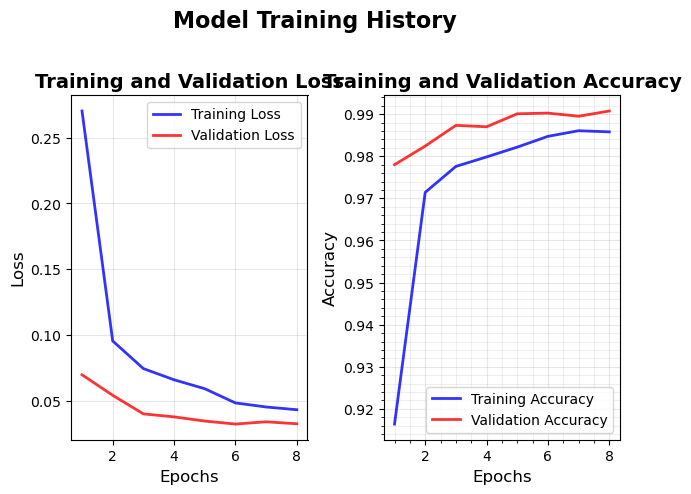

In [9]:
plot_training_history(
    train_losses=training_hist["train_loss"],
    val_losses=training_hist["val_loss"],
    train_accs=training_hist["train_accuracy"],
    val_accs=training_hist["val_accuracy"]
)

## Evaluate Model

In [10]:
eval_results = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=params.device
)

print(f"Test accuracy: {eval_results["accuracy"]}")
print(f"Test loss: {eval_results["test_loss"]}")
print(f"Precision: {eval_results["precision"]}")
print(f"Recall: {eval_results["recall"]}")
print(f"F1 score: {eval_results["F1_score"]}")

Test accuracy: 0.9922
Test loss: 0.02606251994589552
Precision: 0.9922397455237452
Recall: 0.9922
F1 score: 0.9921996917160563


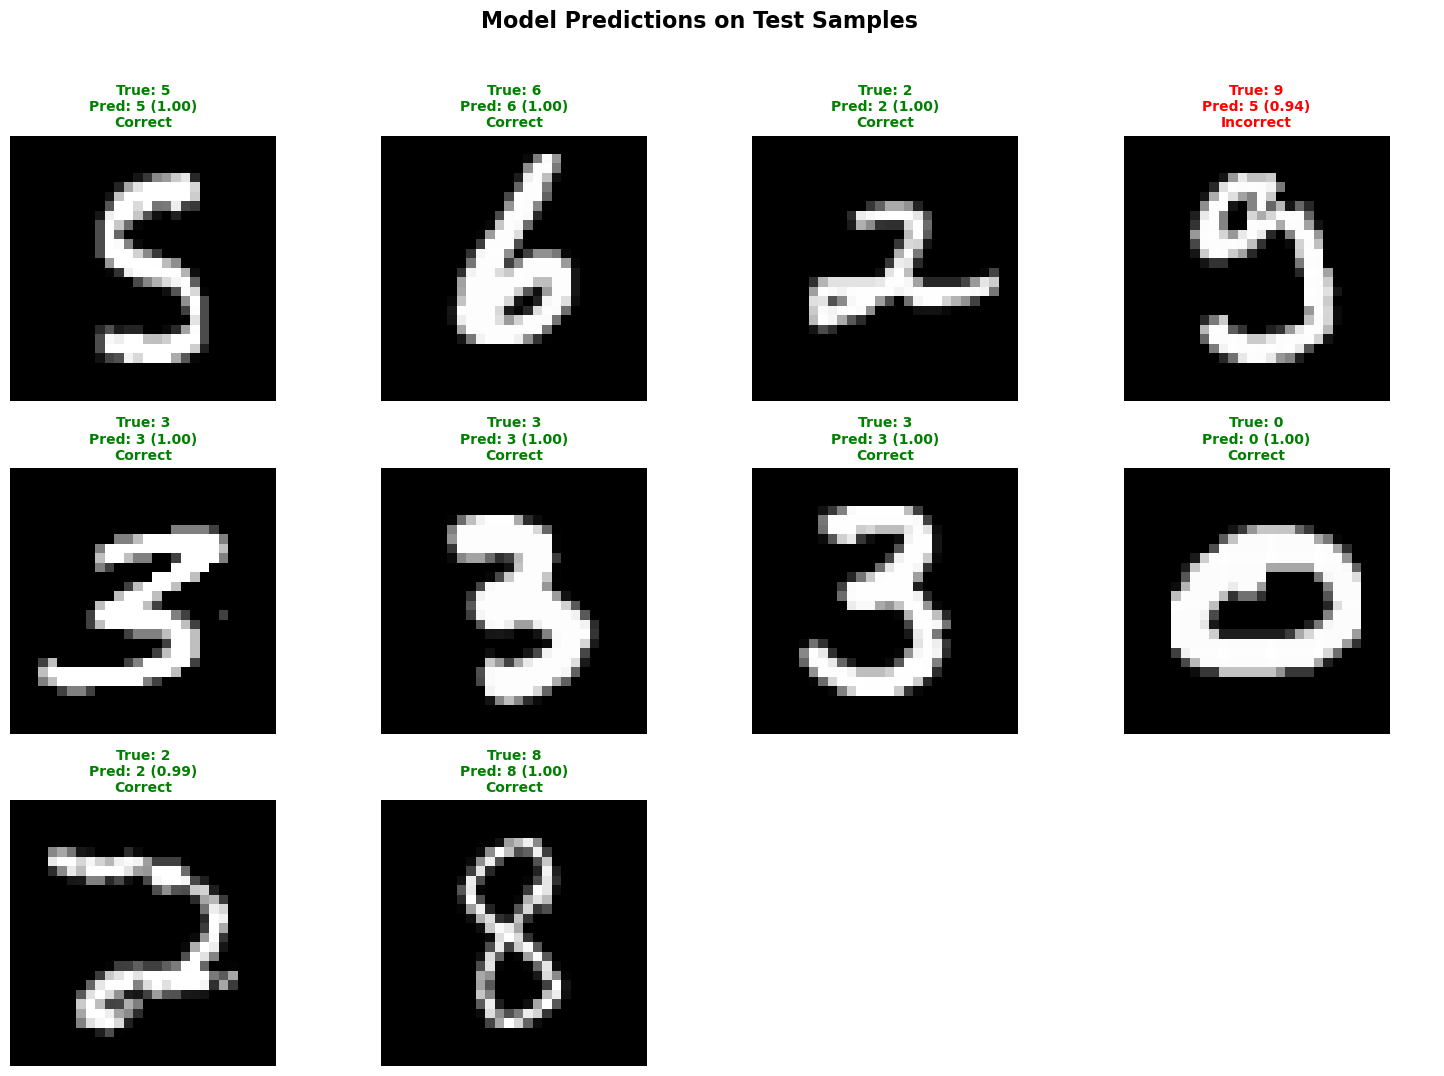

(9, 10)

In [11]:
visualize_predictions(
    model=model,
    test_loader=test_loader,
    device=params.device
)

# Example of Using Inference Script

In [3]:
import inference
from model import DigitRecognizer

Extract one image from the test set for testing inference script

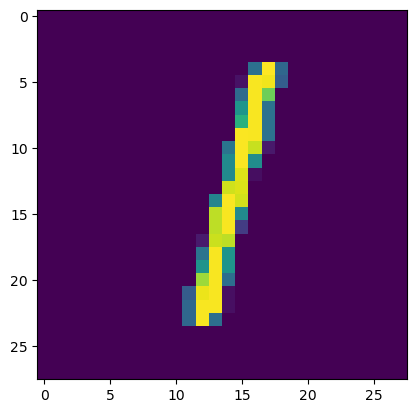

In [4]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

image = images[0]
image = image.reshape(28, 28).numpy()       # (1, 28, 28) to (28, 28); still in [-1, 1]

image = (image * 0.5) + 0.5                 # convert back to [0, 1]
image = (image * 255).astype(np.uint8)      # convert back to [0, 255]

plt.imshow(image)
plt.show()

Perform inference using the trained model

In [5]:
model_path = "best_model.pth"

model_architecture = DigitRecognizer()

predictions = inference.single_image_inference(
    model_path=model_path,
    image_array=image,
    model_architecture=model_architecture
)

Model loaded to: cuda
Predicted result: 1
Probability: 0.9999986886978149
